In [2]:
# Reading files
import pandas as pd
merged_df = pd.read_csv('../data/processed/merged_df.csv',low_memory=False)



In [3]:
#change the name of df
train_df=merged_df

In [4]:
# Drop the 'id' column
train_df.drop(columns=['id'], inplace=True)

# Reduce Size

In [5]:
import pandas as pd

class MemoryReducer:
    def __init__(self, df):
        self.df = df.copy()

    def reduce_memory_usage(self):
        initial_memory = self.df.memory_usage(deep=True).sum() / (1024 ** 2)  # in megabytes
        print(f"Initial Memory Usage: {initial_memory:.2f} MB")

        for col in self.df.columns:
            col_type = self.df[col].dtype

            if col_type != object:
                if "int" in str(col_type):
                    self.df[col] = pd.to_numeric(self.df[col], downcast="integer")
                elif "float" in str(col_type):
                    self.df[col] = pd.to_numeric(self.df[col], downcast="float")
            else:
                num_unique_values = len(self.df[col].unique())
                num_total_values = len(self.df[col])
                if num_unique_values / num_total_values < 0.5:
                    self.df[col] = self.df[col].astype("category")

        reduced_memory = self.df.memory_usage(deep=True).sum() / (1024 ** 2)  # in megabytes
        print(f"Reduced Memory Usage: {reduced_memory:.2f} MB")
        reduction_percentage = ((initial_memory - reduced_memory) / initial_memory) * 100
        print(f"Memory Reduced by: {reduction_percentage:.2f}%")

        return self.df



reducer = MemoryReducer(train_df)
reduced_df = reducer.reduce_memory_usage()


Initial Memory Usage: 25145.41 MB
Reduced Memory Usage: 1168.45 MB
Memory Reduced by: 95.35%


In [6]:
#rename dataframe
df_train=reduced_df

In [7]:
#fill missing value in target
df_train['revenue'].fillna(0, inplace=True)

In [11]:
# Count unique values in the 'date_column'
unique_count = df_train['date'].nunique()
# Display the count of unique date values
print("Count of unique dates:", unique_count)


Count of unique dates: 1541


we have 1541 unique days

In [8]:
# Select only 'Date' and 'Revenue' columns, then group by 'Date' and calculate the total revenue
grouped_df = df_train[['date', 'revenue']].groupby('date')['revenue'].sum().reset_index()

grouped_df.shape

(1541, 2)

In [16]:
#finding d

from statsmodels.tsa.stattools import adfuller
result = adfuller(grouped_df['revenue'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.868248
p-value: 0.347143
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


If the P value is more than 0.05 the time series is not stationary.

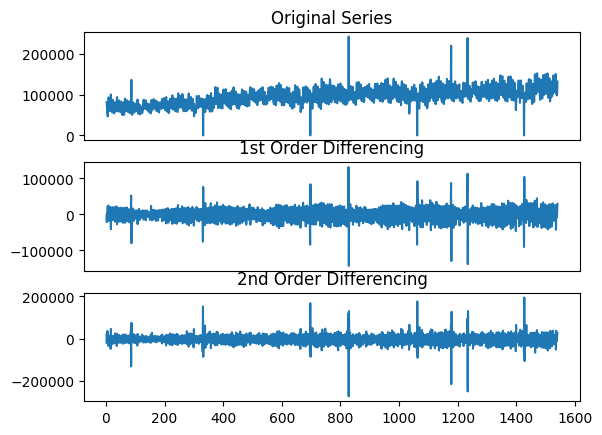

In [17]:
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(grouped_df.revenue); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(grouped_df.revenue.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(grouped_df.revenue.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

Here we can see how the time series has become stationary. 
so optimal D value is 1.

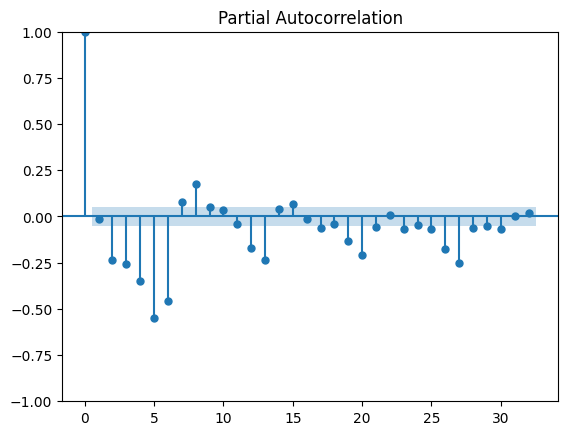

In [15]:
#finding p
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(grouped_df.revenue.diff().dropna());

Here we can see that the first lag is significantly out of the limit and the second one is not out of the significant limit but it is not that far so we can select the order of the p as 1. 

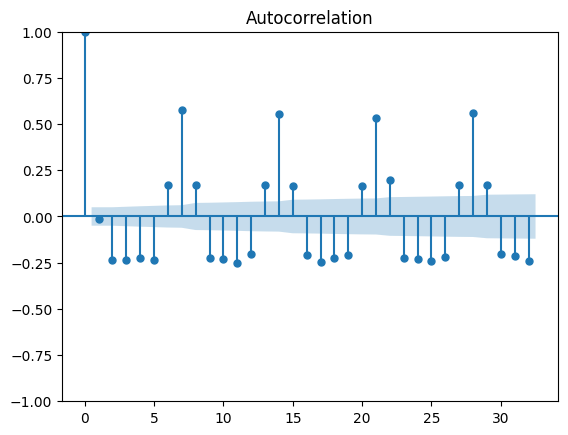

In [14]:
#finding q
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(grouped_df.revenue.diff().dropna());

Here we can see that 4 of the lags are out of the significance limit so we can say that the optimal value of our q (MA) is 2. 

In [20]:
#check the info of grouped df
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1541 entries, 0 to 1540
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   date     1541 non-null   category
 1   revenue  1541 non-null   float32 
dtypes: category(1), float32(1)
memory usage: 53.5 KB


In [21]:
# Convert the 'date' column to datetime
grouped_df['date'] = pd.to_datetime(grouped_df['date'])

# Modeling

In [21]:
# Assuming grouped_df contains your time series data
train_size = int(len(grouped_df) * 0.8)
train_data = grouped_df[:train_size]
test_data = grouped_df[train_size:]


In [151]:
#check the shape
train_data.shape

(1232, 2)

In [17]:
#tail train
train_data.tail()

,date,revenue
1227,2014-06-09,109436.671875
1228,2014-06-10,95818.023438
1229,2014-06-11,97363.578125
1230,2014-06-12,97583.882812
1231,2014-06-13,107753.429688


In [152]:
#check the shape
test_data.shape

(309, 2)

In [18]:
#check the shape
test_data.head()

,date,revenue
1232,2014-06-14,126365.070312
1233,2014-06-15,239490.093750
1234,2014-06-16,101207.296875
1235,2014-06-17,93719.109375
1236,2014-06-18,89381.812500


In [125]:
from statsmodels.tsa.arima.model import ARIMA

# Define your ARIMA order (p, d, q)
p = 1  # Autoregressive order
d = 1  # Differencing order
q = 4  # Moving average order

# Create and fit the ARIMA model
model = ARIMA(train_data['revenue'], order=(p, d, q))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                 1232
Model:                 ARIMA(1, 1, 4)   Log Likelihood              -13492.076
Date:                Sat, 07 Oct 2023   AIC                          26996.152
Time:                        16:35:16   BIC                          27026.846
Sample:                             0   HQIC                         27007.700
                               - 1232                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4143      0.106      3.923      0.000       0.207       0.621
ma.L1         -0.8524      0.108     -7.862      0.000      -1.065      -0.640
ma.L2         -0.3495      0.058     -6.007      0.0

In [126]:
# Make predictions on the test data
forecast = model_fit.forecast(steps=len(test_data))

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(test_data['revenue'], forecast))
print(f'RMSE: {rmse}')

RMSE: 20511.132051649638


In [128]:
# Set the start date for forecasting
start_date = '2014-01-29'  

# Define the forecast period (number of days to forecast)
forecast_period = 7

# Use the ARIMA model results to get the predicted mean values for the next 7 days
forecast_values = model_fit.get_forecast(steps=forecast_period).predicted_mean

# Create a date range for the forecast starting from the specified start_date
forecast_dates = pd.date_range(start=start_date, periods=forecast_period)

# Create a DataFrame to store the forecasted values along with the corresponding dates
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted Revenue': forecast_values})

# Print the forecasted values and dates
print(forecast_df)


           Date  Forecasted Revenue
1232 2014-01-29       107324.627620
1233 2014-01-30       105178.665659
1234 2014-01-31       102787.163709
1235 2014-02-01       103627.405492
1236 2014-02-02       103975.501608
1237 2014-02-03       104119.711178
1238 2014-02-04       104179.454447


In [158]:
#save the model
import joblib
joblib.dump(model_fit, '../models/arima_model.joblib')

['../models/arima_model.joblib']

# SARIMA

it appears that the model is way to simple that couldnt get complexity of data

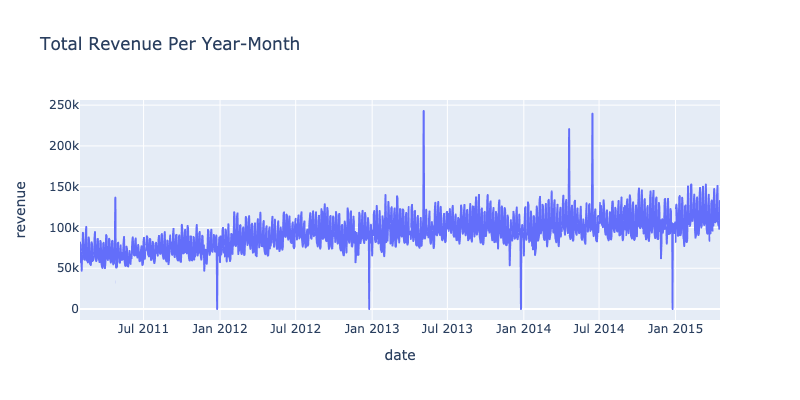

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import Image

# Convert the 'date' column to a datetime type
df_train['date'] = pd.to_datetime(df_train['date'])



# Group by 'year_month' and calculate the sum of 'revenue' for each month
grouped_data = df_train.groupby('date')['revenue'].sum().reset_index()

# Create a line chart using Plotly Express
fig = px.line(grouped_data, x='date', y='revenue', title='Total Revenue Per Year-Month')

# Customize hover text and template
fig.update_traces(text=grouped_data['date'],
                  hovertemplate='Year-Month: %{x}<br>Total Revenue: %{y}')

# Increase the size of the plot
fig.update_layout(width=800, height=400)

# Save the figure as an image and display it
fig_bytes = fig.to_image(format="png")
Image(fig_bytes)


sesonality seems equal to 1 year
it seems that every Jan there is a decrease in revenue.

In [150]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assuming you have already prepared your data and made it stationary

p = 1  # AR order
d = 1  # Differencing order
q = 4  # MA order
P = 4  # Seasonal AR order
D = 1  # Seasonal differencing order
Q = 3  # Seasonal MA order
s = 12  # Seasonal period (1 year)

# Fit SARIMA model
model = SARIMAX(grouped_df['revenue'], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()

# Print summary of the model
print(results.summary())


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11616D+01    |proj g|=  1.06382D-01

At iterate    5    f=  1.11343D+01    |proj g|=  1.46847D-02

At iterate   10    f=  1.11237D+01    |proj g|=  1.19555D-01

At iterate   15    f=  1.11169D+01    |proj g|=  9.80479D-02

At iterate   20    f=  1.11124D+01    |proj g|=  1.63403D-01

At iterate   25    f=  1.11112D+01    |proj g|=  8.16720D-02

At iterate   30    f=  1.11064D+01    |proj g|=  2.14217D-02

At iterate   35    f=  1.11057D+01    |proj g|=  6.08468D-03

At iterate   40    f=  1.11054D+01    |proj g|=  4.33062D-02

At iterate   45    f=  1.11052D+01    |proj g|=  3.54300D-03


/Users/yasamanmohammadi/Library/Caches/pypoetry/virtualenvs/machine-learning-as-a-service-07lCQGgH-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.11051D+01    |proj g|=  4.90044D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     63      1     0     0   4.900D-03   1.111D+01
  F =   11.105064143816884     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                                         SARIMAX Results                                          
Dep. Variable:                                    revenue   No. Observations:                 1541
Model:             SARIMAX(1, 1, 4)x(4, 1, [1, 2, 3], 12)   Log Likelihood              -17112.904
Date:                                    Sat, 07 Oct 2023   AIC 

In [151]:
# Make predictions on the test data
forecast = results.forecast(steps=len(test_data))

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(test_data['revenue'], forecast))
print(f'RMSE: {rmse}')

#Q:3 22406.99949082417

RMSE: 22406.99949082417


In [130]:
forecast_period = 7
forecast_values = results.forecast(steps=forecast_period)


In [132]:
# see if its work
start_date = '2011-01-29'  

# Forecast revenue for the next 7 days
forecast_period = 7
forecast_values = results.get_forecast(steps=forecast_period).predicted_mean

# Create a date range for the forecast
forecast_dates = pd.date_range(start=start_date, periods=forecast_period)

# Print the forecasted values and dates
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted Revenue': forecast_values})
print(forecast_df)

           Date  Forecasted Revenue
1541 2011-01-29       132434.734066
1542 2011-01-30       125655.613943
1543 2011-01-31       108614.614784
1544 2011-02-01       107868.804183
1545 2011-02-02       112524.247841
1546 2011-02-03       103616.067990
1547 2011-02-04       118394.615889


RMSE is greater than ARIMA

In [155]:
#save the model
import joblib
joblib.dump(results, '../models/sarima_model.joblib')

['../models/sarima_model.joblib']